In [1]:
import os, sys
import yfinance as yf
# import ta
import pandas as pd
import numpy as np
import vectorbt as vbt
from datetime import date, timedelta, datetime
from itertools import product
from IPython.display import clear_output
import matplotlib.pyplot as mp
from csv import writer
import warnings

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/telegram/utils/request.py:49: UserWarning: python-telegram-bot is using upstream urllib3. This is allowed but not supported by python-telegram-bot maintainers.
  warnings.warn(


In [2]:
warnings.filterwarnings('ignore')

Strategies

RSI and Moving Average Crossover Strategy Indicators: \
1. RSI (21), 5 Exponential Moving Average (EMA), 12 Exponential Moving Average (EMA).
2. Entry Rules:Buy Signal: When the 5EMA crosses above the 12EMA and the RSI crosses above the 50 level.
3. Sell Signal: When the 5EMA crosses below the 12EMA and the RSI crosses below the 50 level.
4. Stop Loss/Take Profit: Set a stop loss of 15 pips and a take profit of 30 pips.
5. Example: If you are trading EUR/USD on a 30-minute chart and the 5EMA crosses above the 12EMA while the RSI crosses above 50, you would enter a buy position. Conversely, if the 5EMA crosses below the 12EMA and the RSI crosses below 50, you would enter a sell position .

In [19]:
def execute_main(list_of_tickers, interval='1d', rsi_window=21, entry=30, exit=70, slow=12, fast=5):
    # dt_range = pd.date_range('2019-12-31', '2020-12-31', freq='6m') 
    # define start and end date
    # end_date = datetime.now()-timedelta(days=30)
    # start_date = end_date - timedelta(days=390)

    end_date = datetime.now()
    start_date = end_date - timedelta(days=360)

    # extract data from yahoo finanace
    btc_price = vbt.YFData.download(
    list_of_tickers,
    interval=interval,
    start = start_date,
    end = end_date,
    missing_index='drop').get("Close")

    # Initialize a Indicator Factory using custom indicator
    # Step2. Receipe how to create an indicator
    ind = vbt.IndicatorFactory(
        class_name = "Combination",
        short_name = "comb",
        input_names = ["close"],
        param_names = ["rsi_window", "entry", "exit", "slow", "fast"],
        output_names = ["value"]
    ).from_apply_func(
        custom_indicator,
        rsi_window=rsi_window,
        entry=entry, 
        exit=exit, 
        slow=slow, 
        fast=fast
    )

    # Step3. execute the custom indicator with the given parameters
    res = ind.run(
        btc_price,
    )

    # return (res, btc_price)

    stats_dict = {}

    # Results
    for _col in res.value.columns:
        print("-------------------{}------------------------------".format(_col))
        _asset = res.value[_col].to_numpy()
        _entry = np.where(_asset==1, True, False)
        _exit = np.where(_asset==-1, True, False)
        
        pf = vbt.Portfolio.from_signals(btc_price[_col], _entry, _exit)
        print(pf.stats())
        stats_dict[_col]=pf.stats()
        print(pf)
        pf.plot(title=_col).show()
        print("----------------------------------------------------------")

    return (res, btc_price, stats_dict)

In [20]:
# Step 1. Create a custom indicator
def custom_indicator(close, rsi_window=14, entry=30, exit=70, slow=50, fast=10):
    rsi= vbt.RSI.run(close, window=rsi_window)
    rsi_above = rsi.rsi_above(exit).to_numpy()
    rsi_below = rsi.rsi_above(entry).to_numpy()
    slow_ma = vbt.MA.run(close, slow)
    fast_ma = vbt.MA.run(close, fast)
    entries = fast_ma.ma_crossed_above(slow_ma).to_numpy()
    exits = fast_ma.ma_crossed_below(slow_ma).to_numpy()
    # we will create a signal
    # For example rsi between 35 and 70, and price will be above ma,we will buy
    trend = np.where(rsi_above & exits, -1, 0) # Exit
    trend = np.where(rsi_below & entries, 1, trend)
    return trend

In [21]:
tickers=["MSFT", "AMZN", "NAT", "BAC"]

-------------------MSFT------------------------------
Start                         2023-11-13 05:00:00+00:00
End                           2024-11-04 05:00:00+00:00
Period                                              246
Start Value                                       100.0
End Value                                    109.946009
Total Return [%]                               9.946009
Benchmark Return [%]                          12.230251
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              15.486783
Max Drawdown Duration                              85.0
Total Trades                                          1
Total Closed Trades                                   0
Total Open Trades                                     1
Open Trade PnL                                 9.946009
Win Rate [%]                                        NaN
Best Trade [%]                                    

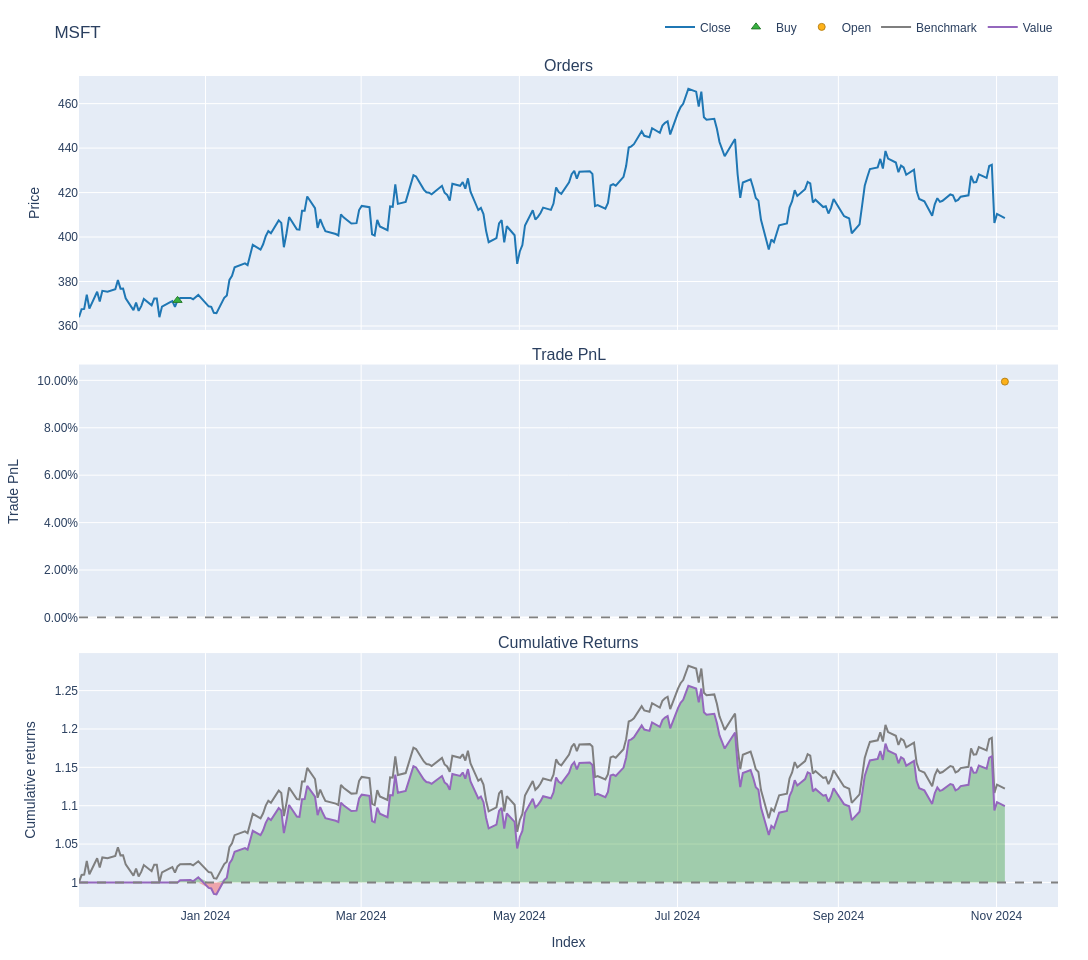

----------------------------------------------------------
-------------------AMZN------------------------------
Start                         2023-11-13 05:00:00+00:00
End                           2024-11-04 05:00:00+00:00
Period                                              246
Start Value                                       100.0
End Value                                    131.537224
Total Return [%]                              31.537224
Benchmark Return [%]                          37.302759
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              19.489998
Max Drawdown Duration                              85.0
Total Trades                                          1
Total Closed Trades                                   0
Total Open Trades                                     1
Open Trade PnL                                31.537224
Win Rate [%]                                   

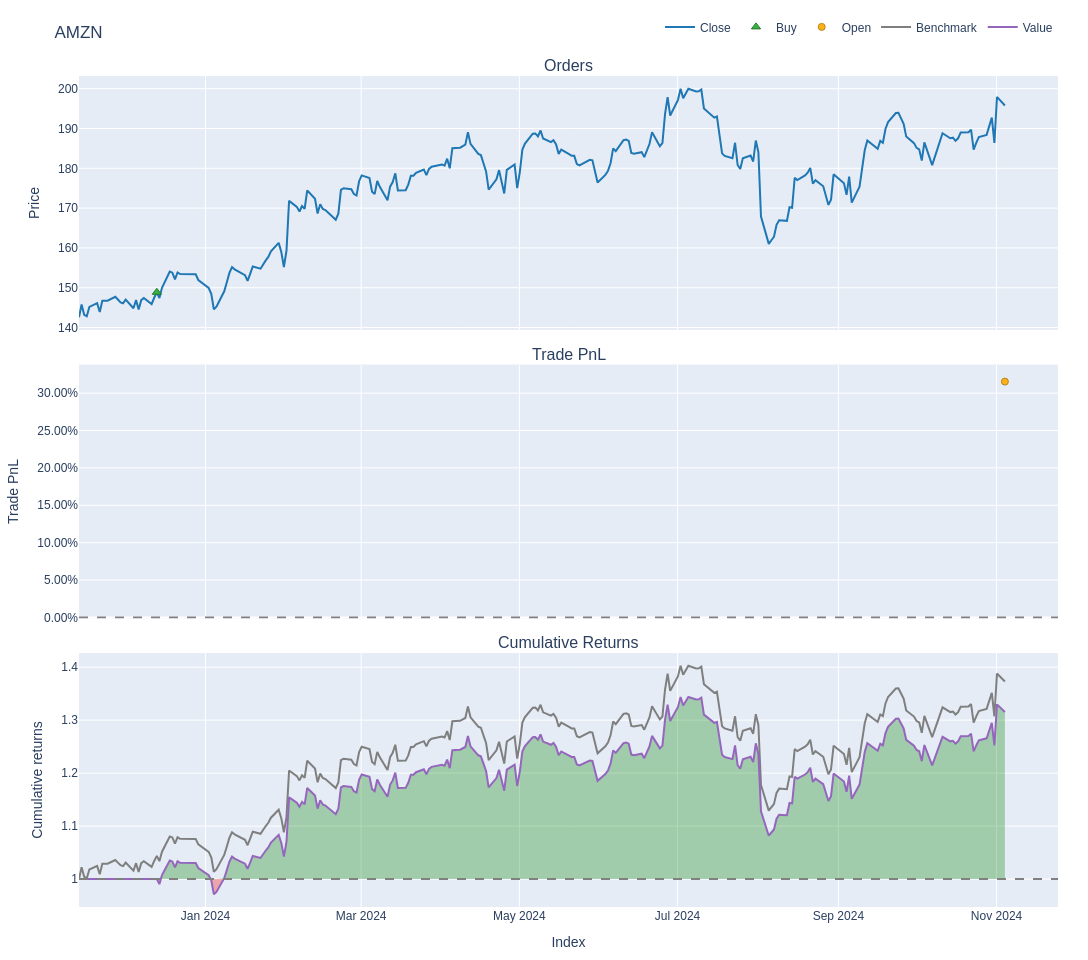

----------------------------------------------------------
-------------------NAT------------------------------
Start                         2023-11-13 05:00:00+00:00
End                           2024-11-04 05:00:00+00:00
Period                                              246
Start Value                                       100.0
End Value                                     83.249479
Total Return [%]                             -16.750521
Benchmark Return [%]                         -24.154497
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              24.418244
Max Drawdown Duration                             209.0
Total Trades                                          1
Total Closed Trades                                   0
Total Open Trades                                     1
Open Trade PnL                               -16.750521
Win Rate [%]                                    

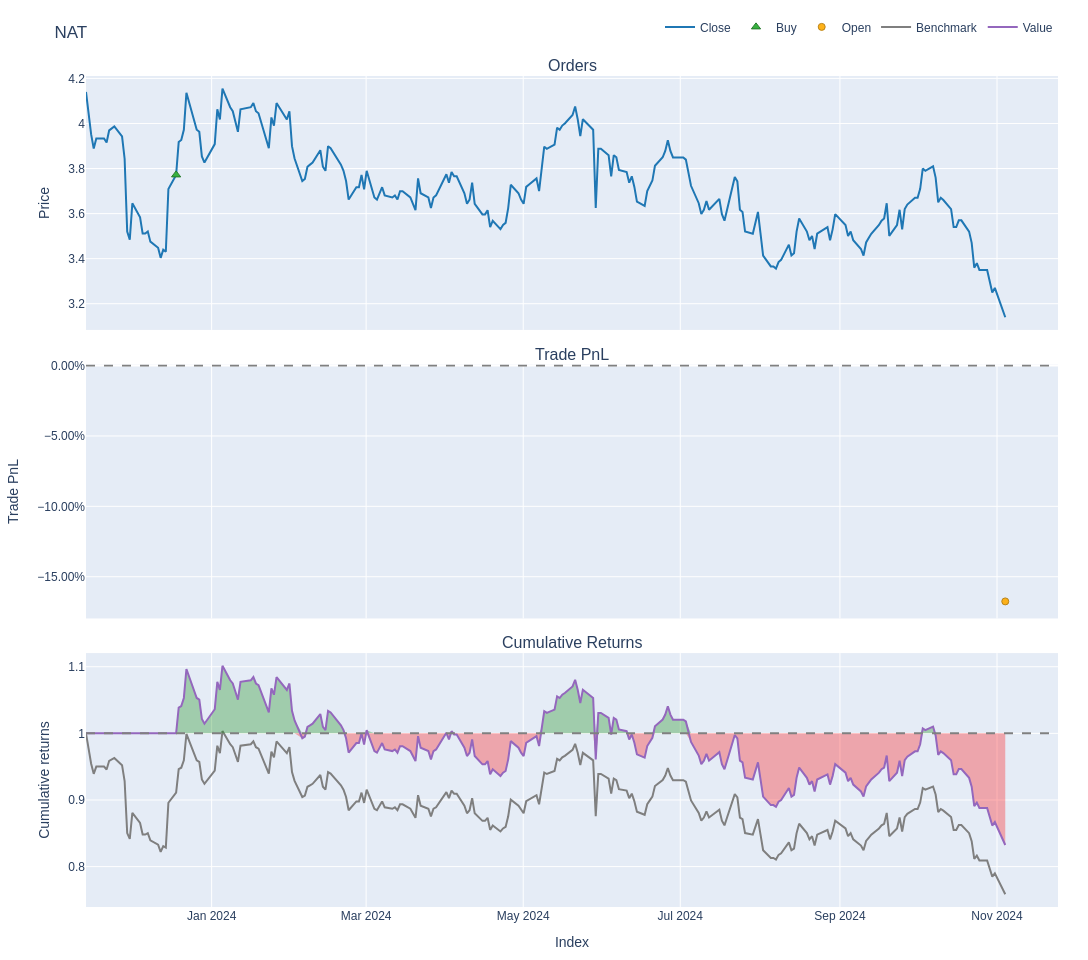

----------------------------------------------------------
-------------------BAC------------------------------
Start                         2023-11-13 05:00:00+00:00
End                           2024-11-04 05:00:00+00:00
Period                                              246
Start Value                                       100.0
End Value                                    126.227282
Total Return [%]                              26.227282
Benchmark Return [%]                          53.370686
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               16.94992
Max Drawdown Duration                              78.0
Total Trades                                          1
Total Closed Trades                                   0
Total Open Trades                                     1
Open Trade PnL                                26.227282
Win Rate [%]                                    

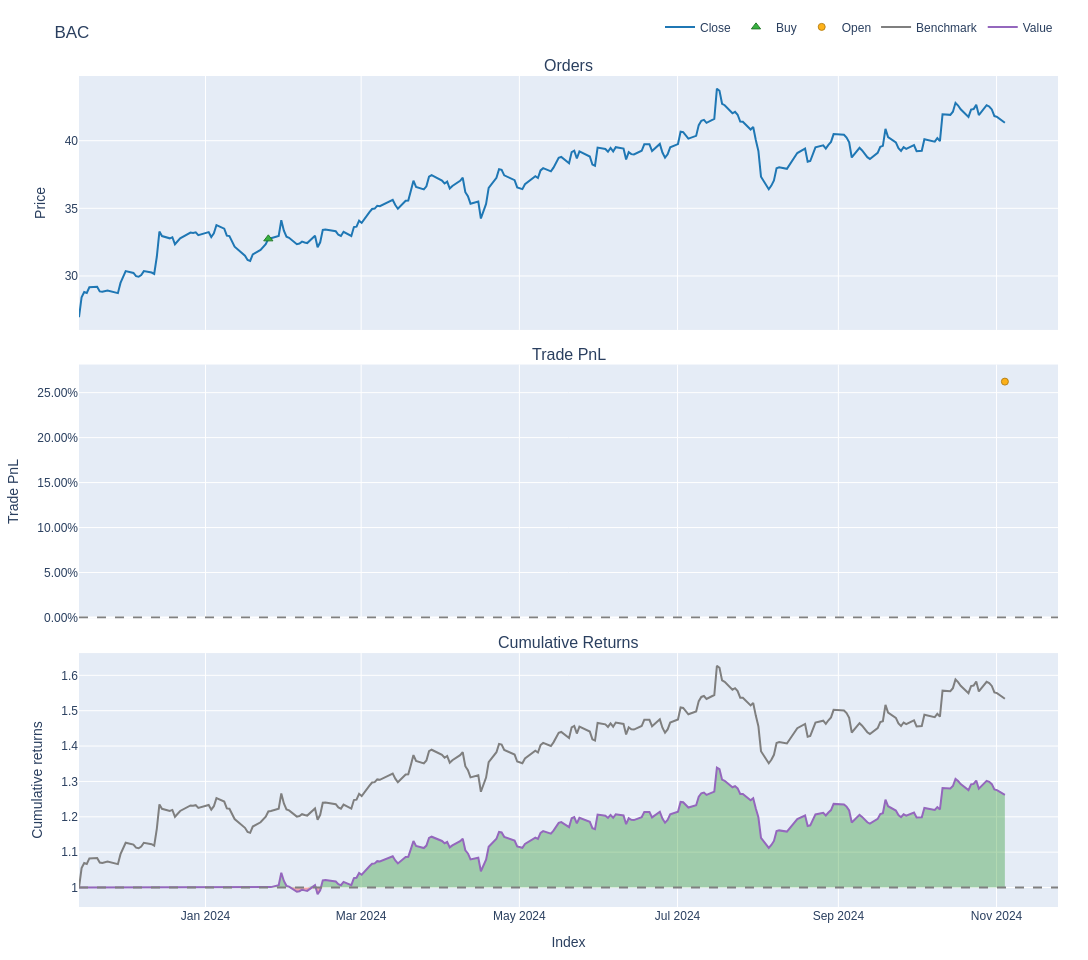

----------------------------------------------------------


In [22]:
# res, btc_price  = execute_main()

res, btc_price, stats_dict = execute_main(tickers)

In [26]:
stats_dict

{'MSFT': Start                         2023-11-13 05:00:00+00:00
 End                           2024-11-04 05:00:00+00:00
 Period                                              246
 Start Value                                       100.0
 End Value                                    109.946009
 Total Return [%]                               9.946009
 Benchmark Return [%]                          12.230251
 Max Gross Exposure [%]                            100.0
 Total Fees Paid                                     0.0
 Max Drawdown [%]                              15.486783
 Max Drawdown Duration                              85.0
 Total Trades                                          1
 Total Closed Trades                                   0
 Total Open Trades                                     1
 Open Trade PnL                                 9.946009
 Win Rate [%]                                        NaN
 Best Trade [%]                                      NaN
 Worst Trade [%]       

In [7]:
df_tech = pd.DataFrame(stats_dict)

In [8]:
tech_keys = [i for i in stats_dict['AMZN'].keys()]

In [9]:
tech_keys

['Start',
 'End',
 'Period',
 'Start Value',
 'End Value',
 'Total Return [%]',
 'Benchmark Return [%]',
 'Max Gross Exposure [%]',
 'Total Fees Paid',
 'Max Drawdown [%]',
 'Max Drawdown Duration',
 'Total Trades',
 'Total Closed Trades',
 'Total Open Trades',
 'Open Trade PnL',
 'Win Rate [%]',
 'Best Trade [%]',
 'Worst Trade [%]',
 'Avg Winning Trade [%]',
 'Avg Losing Trade [%]',
 'Avg Winning Trade Duration',
 'Avg Losing Trade Duration',
 'Profit Factor',
 'Expectancy']

In [277]:
fund_key = ['auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk', 'dividendRate', 'dividendYield', 'exDividendDate', 'payoutRatio', 'fiveYearAvgDividendYield', 'beta', 'trailingPE', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'priceToSalesTrailing12Months', 'fiftyDayAverage', 'twoHundredDayAverage', 'trailingAnnualDividendRate', 'trailingAnnualDividendYield', 'currency', 'enterpriseValue', 'profitMargins', 'floatShares', 'sharesOutstanding', 'sharesShort', 'sharesShortPriorMonth', 'sharesShortPreviousMonthDate', 'heldPercentInsiders', 'heldPercentInstitutions', 'shortRatio', 'shortPercentOfFloat', 'impliedSharesOutstanding', 'bookValue', 'priceToBook', 'earningsQuarterlyGrowth', 'netIncomeToCommon', 'trailingEps', 'forwardEps', 'pegRatio', 'enterpriseToRevenue', 'enterpriseToEbitda', '52WeekChange', 'SandP52WeekChange', 'lastDividendValue', 'lastDividendDate', 'quoteType', 'symbol', 'shortName', 'longName', 'currentPrice', 'targetHighPrice', 'targetLowPrice', 'targetMeanPrice', 'targetMedianPrice', 'recommendationMean', 'recommendationKey', 'numberOfAnalystOpinions', 'totalCash', 'totalCashPerShare', 'ebitda', 'totalDebt', 'quickRatio', 'currentRatio', 'totalRevenue', 'debtToEquity', 'revenuePerShare', 'returnOnAssets', 'returnOnEquity', 'freeCashflow', 'operatingCashflow', 'earningsGrowth', 'revenueGrowth', 'grossMargins', 'ebitdaMargins', 'operatingMargins', 'financialCurrency', 'trailingPegRatio']
fundamental = {}

for _tick in tickers:
    fund = yf.Ticker(_tick).info
    fundamental[_tick] = {k : fund.get(k, np.NaN) for k in fund_key}

In [278]:
fundamental

{'MSFT': {'auditRisk': 3,
  'boardRisk': 4,
  'compensationRisk': 2,
  'shareHolderRightsRisk': 2,
  'overallRisk': 1,
  'dividendRate': 3.32,
  'dividendYield': 0.0081,
  'exDividendDate': 1732147200,
  'payoutRatio': 0.2477,
  'fiveYearAvgDividendYield': 0.88,
  'beta': 0.896,
  'trailingPE': 33.88687,
  'forwardPE': 27.285238,
  'volume': 23745361,
  'regularMarketVolume': 23745361,
  'averageVolume': 19282200,
  'averageVolume10days': 23027940,
  'averageDailyVolume10Day': 23027940,
  'bid': 410.29,
  'ask': 410.52,
  'bidSize': 100,
  'askSize': 200,
  'marketCap': 3051051548672,
  'fiftyTwoWeekLow': 353.35,
  'fiftyTwoWeekHigh': 468.35,
  'priceToSalesTrailing12Months': 12.003036,
  'fiftyDayAverage': 420.6874,
  'twoHundredDayAverage': 420.8283,
  'trailingAnnualDividendRate': 3.08,
  'trailingAnnualDividendYield': 0.0075796726,
  'currency': 'USD',
  'enterpriseValue': 3069461135360,
  'profitMargins': 0.35608003,
  'floatShares': 7424620641,
  'sharesOutstanding': 7434880000,


In [279]:
df_fund = pd.DataFrame(fundamental)

In [280]:
df_fund.loc['beta']

MSFT    0.896
AMZN      NaN
NAT     -0.21
BAC     1.338
Name: beta, dtype: object

In [281]:
df_fund.T['beta']

MSFT    0.896
AMZN      NaN
NAT     -0.21
BAC     1.338
Name: beta, dtype: object

In [282]:
df = pd.concat([df_tech,df_fund], axis=0, ignore_index=False)

In [283]:
df = df.T

In [293]:
df['Start']=pd.to_datetime(df['Start']).dt.strftime("%Y-%m-%d")

In [295]:
df['End']=pd.to_datetime(df['End']).dt.strftime("%Y-%m-%d")

In [299]:
df[['Start', 'End','beta', 'Total Return [%]', 'Benchmark Return [%]', 'Max Gross Exposure [%]']]

,Start,End,beta,Total Return [%],Benchmark Return [%],Max Gross Exposure [%]
MSFT,2024-08-05,2024-11-01,0.896,-3.894615,4.038885,100.0
AMZN,2024-08-05,2024-11-01,NaN,15.485147,22.92261,100.0
NAT,2024-08-05,2024-11-01,-0.21,-9.21025,-3.731558,100.0
BAC,2024-08-05,2024-11-01,1.338,2.177635,14.685555,100.0


In [271]:
# Return all the assets with positive return percentage

df = df[df["Total Return [%]"]>0]

In [298]:
14*5

70

In [272]:
df

,Start,End,Period,Start Value,End Value,Total Return [%],Benchmark Return [%],Max Gross Exposure [%],Total Fees Paid,Max Drawdown [%],...,returnOnEquity,freeCashflow,operatingCashflow,earningsGrowth,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins,financialCurrency,trailingPegRatio
AMZN,2024-08-05 04:00:00+00:00,2024-11-01 04:00:00+00:00,64,100.0,115.485147,15.485147,22.92261,100.0,0.0,6.784906,...,0.22558,71359250432,112706002944,0.521,0.11,0.48406,0.17994,0.10959,USD,1.7133
BAC,2024-08-05 04:00:00+00:00,2024-11-01 04:00:00+00:00,64,100.0,102.177635,2.177635,14.685555,100.0,0.0,4.037186,...,0.08092,NaN,-1995000064,-0.1,-0.005,NaN,NaN,0.30769,USD,1.9016


MSFT      NaN
AMZN    1.147
BAC     1.338
Name: beta, dtype: object

In [228]:
for i in df.columns:
    print(i)

Start
End
Period
Start Value
End Value
Total Return [%]
Benchmark Return [%]
Max Gross Exposure [%]
Total Fees Paid
Max Drawdown [%]
Max Drawdown Duration
Total Trades
Total Closed Trades
Total Open Trades
Open Trade PnL
auditRisk
boardRisk
compensationRisk
shareHolderRightsRisk
overallRisk
dividendRate
dividendYield
exDividendDate
payoutRatio
fiveYearAvgDividendYield
beta
trailingPE
forwardPE
volume
regularMarketVolume
averageVolume
averageVolume10days
averageDailyVolume10Day
bid
ask
bidSize
askSize
marketCap
fiftyTwoWeekLow
fiftyTwoWeekHigh
priceToSalesTrailing12Months
fiftyDayAverage
twoHundredDayAverage
trailingAnnualDividendRate
trailingAnnualDividendYield
currency
enterpriseValue
profitMargins
floatShares
sharesOutstanding
sharesShort
sharesShortPriorMonth
sharesShortPreviousMonthDate
heldPercentInsiders
heldPercentInstitutions
shortRatio
shortPercentOfFloat
impliedSharesOutstanding
bookValue
priceToBook
earningsQuarterlyGrowth
netIncomeToCommon
trailingEps
forwardEps
pegRatio
en

In [297]:
df['Period']

MSFT    64
AMZN    64
NAT     64
BAC     64
Name: Period, dtype: object

In [ ]:
dictionary = 
{'Start':'Start date',
'End': 'End date',
'Period':'Number of closing price considered as per frequency',
'Start Value',
'End Value',
'Total Return [%]':'The actual rate of return realized over some evaluation period',
'Benchmark Return [%]':'The performance of a predetermined set of securities, used for comparison purpose',
'Max Gross Exposure [%]':'Gross exposure is the total sum of the long positions and short positions. \
Leverage: When gross exposure is greater than 100%, the fund is using leverage, or borrowing money to increase return\
; Cash: When gross exposure is less than 100%, a portion of the portfolio is invested in cash; \
Risk: A fund's overall exposure is better indicated by considering both its net exposure and its gross exposure. \
For example, a fund with a net long exposure of 20% and a gross exposure of 100% is fully invested and has a lower risk than a \
fund with the same net exposure but a gross exposure of 180%.',
'Total Fees Paid':'',
'Max Drawdown [%]':'Maximum drawdown(MDD) is a metric that measures the larget percentage loss a portfolio can experience between a peak and trough',
'Max Drawdown Duration',
'Total Trades',
'Total Closed Trades',
'Total Open Trades':'Total open trade or open trade equity(OTE) is the amount of unrealized gain or loss on a traders open position',
'Open Trade PnL': 'Open PnL measures the amount of money gained or lost from the begining of the trade or the moment you opened the position',
'auditRisk',
'boardRisk',
'compensationRisk',
'shareHolderRightsRisk',
'overallRisk',
'dividendRate',
'dividendYield',
'exDividendDate',
'payoutRatio',
'fiveYearAvgDividendYield',
'beta',
'trailingPE',
'forwardPE',
'volume',
'regularMarketVolume',
'averageVolume',
'averageVolume10days',
'averageDailyVolume10Day',
'bid',
'ask',
'bidSize',
'askSize',
'marketCap',
'fiftyTwoWeekLow',
'fiftyTwoWeekHigh',
'priceToSalesTrailing12Months',
'fiftyDayAverage',
'twoHundredDayAverage',
'trailingAnnualDividendRate',
'trailingAnnualDividendYield',
'currency',
'enterpriseValue',
'profitMargins',
'floatShares',
'sharesOutstanding',
'sharesShort',
'sharesShortPriorMonth',
'sharesShortPreviousMonthDate',
'heldPercentInsiders',
'heldPercentInstitutions',
'shortRatio',
'shortPercentOfFloat',
'impliedSharesOutstanding',
'bookValue',
'priceToBook',
'earningsQuarterlyGrowth',
'netIncomeToCommon',
'trailingEps',
'forwardEps',
'pegRatio',
'enterpriseToRevenue',
'enterpriseToEbitda',
'52WeekChange',
'SandP52WeekChange',
'lastDividendValue',
'lastDividendDate',
'quoteType',
'symbol',
'shortName',
'longName',
'currentPrice',
'targetHighPrice',
'targetLowPrice',
'targetMeanPrice',
'targetMedianPrice',
'recommendationMean',
'recommendationKey',
'numberOfAnalystOpinions',
'totalCash',
'totalCashPerShare',
'ebitda',
'totalDebt',
'quickRatio',
'currentRatio',
'totalRevenue',
'debtToEquity',
'revenuePerShare',
'returnOnAssets',
'returnOnEquity',
'freeCashflow',
'operatingCashflow',
'earningsGrowth',
'revenueGrowth',
'grossMargins',
'ebitdaMargins',
'operatingMargins',
'financialCurrency',
'trailingPegRatio',